In [1]:
# included modules necessary for the code for this notebook.
import xarray as xr
import os
import numpy as np
import gsw
from netCDF4 import Dataset
import glob
import netCDF4 as nc
import numpy.ma as ma
import matplotlib.pyplot as plt
import cmocean
from numpy import savetxt
from scipy.stats import skew
import pandas as pd
import csv
from scipy.signal import butter, filtfilt

Here we are showing the timeseries for the energetics in the Santa Barbara Channel. As with Figure 1, some of the computations were completed separately and saved so they weren't re-run everytime the figure needed to be generated. As such, equations rather than straight data are shown here and you can complete the necessary calculations as they make sense to you.

### Total KE and EKE for scales smaller than 7 km - Figure 2(a)

For KE at scales smaller than 7 km - use the velocity for scales smaller than 7 km (see script for figure 1) and calculate KE = 1/2($u^2$+$v^2$)
Do the same thing but the EKE but now, subtract out the time mean to retrieve just the eddy component (EKE = 1/2(($u-u_{mean})^2$+($v-v_{mean})^2$))
Same 48-hour tidal filter applies to the timeseries. And a butterworth filter was also applied to smooth out an other small scale variations.
Gaps in the time series are explained in the next section for Figure 2(b) given the correlation with the wind data

In [2]:
# Loading in the timeseries, having computed them separately and saved them so they were rerun everytime I wanted to generate the figure of the 12 years.
filteredseasonalke7 = np.loadtxt('/export/data1/staylor2/HF Radar/scripts/GRL figures/filteredseasonalke7.txt')
filteredseasonaleke7 = np.loadtxt('/export/data1/staylor2/HF Radar/scripts/GRL figures/filteredseasonaleke7.txt')

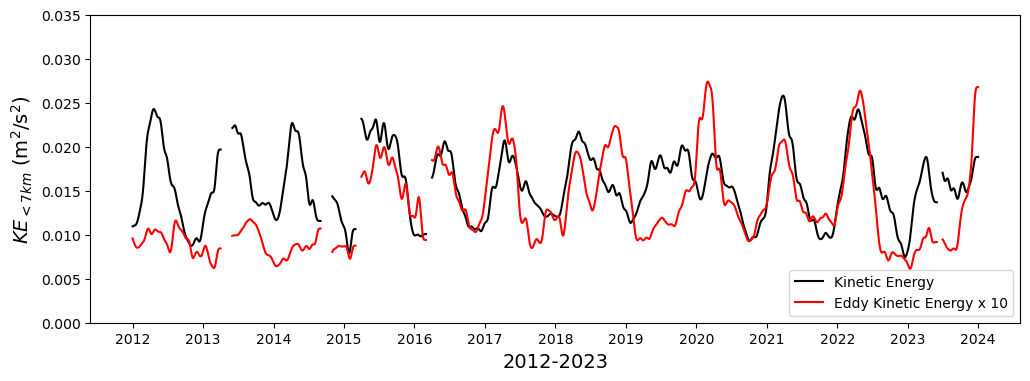

In [13]:
plt.figure(figsize=(12,4))
plt.plot(filteredseasonalke7, c='k', label = 'Kinetic Energy')
plt.plot(filteredseasonaleke7*10, c= 'r', label='Eddy Kinetic Energy x 10')

tickpositions = [0, 8784,17544, 26304, 35064, 43848, 52608, 61368, 70128, 78912, 87672, 96432, 105191]
ticklabels = ['2012', '2013', '2014', '2015', '2016', '2017', '2018', '2019', '2020', '2021', '2022', '2023', '2024'] 
plt.xticks(tickpositions, ticklabels)
plt.ylim(0, 0.035)
plt.legend(loc='lower right')
plt.ylabel(r'$KE_{<7 km}$ (m$^2$/s$^2$)', fontsize=14)
plt.xlabel('2012-2023', fontsize=14)
plt.savefig("KEtimeseries.jpg", dpi=300)
plt.show()

### wind (work)and vorticity - Figure 2(b) and (c)

In [4]:
# Loading in the wind data downloaded from Copernicus for 2012-2023, and saved to the server
a = xr.open_mfdataset('/export/data1/staylor2/HF Radar/Data/Wind data/2012 wind data.nc', parallel=True)
b = xr.open_mfdataset('/export/data1/staylor2/HF Radar/Data/Wind data/2013 wind data.nc', parallel=True)
c = xr.open_mfdataset('/export/data1/staylor2/HF Radar/Data/Wind data/2014 wind data.nc', parallel=True)
d = xr.open_mfdataset('/export/data1/staylor2/HF Radar/Data/Wind data/2015 wind data.nc', parallel=True)
e = xr.open_mfdataset('/export/data1/staylor2/HF Radar/Data/Wind data/2016 wind data.nc', parallel=True)
f = xr.open_mfdataset('/export/data1/staylor2/HF Radar/Data/Wind data/2017 wind data.nc', parallel=True)
g = xr.open_mfdataset('/export/data1/staylor2/HF Radar/Data/Wind data/2018 wind data.nc', parallel=True)
h = xr.open_mfdataset('/export/data1/staylor2/HF Radar/Data/Wind data/2019 wind data.nc', parallel=True)
w = xr.open_mfdataset('/export/data1/staylor2/HF Radar/Data/Wind data/2020 wind data.nc', parallel=True)
q = xr.open_mfdataset('/export/data1/staylor2/HF Radar/Data/Wind data/2021 wind data.nc', parallel=True)
r = xr.open_mfdataset('/export/data1/staylor2/HF Radar/Data/Wind data/2022 wind data.nc', parallel=True)
s = xr.open_mfdataset('/export/data1/staylor2/HF Radar/Data/Wind data/2023 wind data.nc', parallel=True)

In [5]:
# pulling the u- and v-components of the .nc files for 2012-2023 in the region
latitude = a['latitude'].values
longitude = a['longitude'].values
uvel12 = a['u10'].values
vvel12 = a['v10'].values

uvel13 = b['u10'].values
vvel13 = b['v10'].values

uvel14 = c['u10'].values
vvel14 = c['v10'].values

uvel15 = d['u10'].values
vvel15 = d['v10'].values

uvel16 = e['u10'].values
vvel16 = e['v10'].values

uvel17 = f['u10'].values
vvel17 = f['v10'].values

uvel18 = g['u10'].values
vvel18 = g['v10'].values

uvel19 = h['u10'].values
vvel19 = h['v10'].values

uvel20 = w['u10'].values
vvel20 = w['v10'].values

uvel21 = q['u10'].values
vvel21 = q['v10'].values

uvel22 = r['u10'].values
vvel22 = r['v10'].values

uvel23 = s['u10'].values
vvel23 = s['v10'].values

In [6]:
"""
concatenating for all years and narrowing the spatial field to the Santa Barbara Channel.
I find it useful to download a larger area than the focus of study just in case.
"""
u10 = np.concatenate((uvel12, uvel13, uvel14, uvel15, uvel16, uvel17, uvel18, uvel19, uvel20, uvel21, uvel22, uvel23))
v10 = np.concatenate((vvel12, vvel13, vvel14, vvel15, vvel16, vvel17, vvel18, vvel19, vvel20, vvel21, vvel22, vvel23))
u = np.nanmean(u10[:,2:5,2:6], axis=(1,2))
v = np.nanmean(v10[:,2:5,2:6], axis=(1,2))

In [7]:
# Filtering the wind with the same 48-hour shifted window. Even though there are no tidal effects, the averages should be the same to compare like to like.
ufilvel = []
for p in range(0, len(u)):
    ufilvel.append(np.nanmean(u[p:(p+48)]))
    
vfilvel = []
for p in range(0, len(v)):
    vfilvel.append(np.nanmean(v[p:(p+48)]))

Below I am just calculating the wind speed, which will be later used to calculate the wind work

In [8]:
# Calculating the magnitude of the wind speed
speed = np.sqrt(np.array(ufilvel)**2+np.array(vfilvel)**2)

In [9]:
# Calculating the shifted seasonal (~3 month) average to show seasonal variation
seasonalwind = []
for p in range(0, (105192)):
    seasonalwind.append(np.nanmean(speed[p:(p+2193)]))

In [2]:
"""
Applying the butterworth filter alluded to with the KE calculations (and the same is used for the vorticity time series)
Here you see the general code and functions used for this filter that can be applied to other time series for this study
"""
hours = len(seasonalwind)
t = np.arange(hours)  # Time vector in hours to pass through the butterworth filter function
data = seasonalwind
T = 1  # Sampling interval in hours
fs = 1 / T  # Sampling frequency in cycles per hour
nyquist = 0.5 * fs  # Nyquist frequency in cycles per hour

cutoff = 1 / 732  # Desired cutoff frequency in cycles per hour (1 cycle per x months)
normal_cutoff = cutoff / nyquist  # Normalise by Nyquist frequency

# the butterworth_filter function below filters out high frequency variations to make the long term seasonal variations clearer
def butterworth_filter(data, normal_cutoff, order=5, filter_type='low'):
    b, a = butter(order, normal_cutoff, btype=filter_type, analog=False)
    y = filtfilt(b, a, data)
    return y

filteredseasonalwind = butterworth_filter(data, normal_cutoff, order=5, filter_type='low')

This is where I chunk the wind work to align with where there are gaps in the HF radar data sets. There are (as yet) unexplained gaps in the HF radar but it is not clear what days/hours these occur so I drop the entire month and the sectioning below alludes to those months dropped. Again, depending on the years and months pulled, the indices might be different

In [11]:
# Calculating the wind work (see equation (2) in manuscript)
ww1 = -1.225/1025*0.0015/44.5*speed[0:10944]*2*EKE7[0:10944]
ww2 = -1.225/1025*0.0015/44.5*speed[12408:23376]*2*EKE7[11357:22325]
ww3 = -1.225/1025*0.0015/44.5*speed[24840:27720]*2*EKE7[23736:26616]
ww4 = -1.225/1025*0.0015/44.5*speed[28464:36504]*2*EKE7[27356:35396]
ww5 = -1.225/1025*0.0015/44.5*speed[37248:100056]*2*EKE7[36138:98946]
ww6 = -1.225/1025*0.0015/44.5*speed[100776:105192]*2*EKE7[99658:104074]

In [12]:
# seasonal average to entire wind work
seasonalww1 = []
seasonalww2 = []
seasonalww3 = []
seasonalww4 = []
seasonalww5 = []
seasonalww6 = []

for p in range(0, (len(ww1))):
    seasonalww1.append(np.nanmean(ww1[p:p+2193]))
    
for p in range(0, (len(ww2))):
    seasonalww2.append(np.nanmean(ww2[p:p+2193]))
    
for p in range(0, (len(ww3))):
    seasonalww3.append(np.nanmean(ww3[p:p+2193]))
    
for p in range(0, (len(ww4))):
    seasonalww4.append(np.nanmean(ww4[p:p+2193]))
    
for p in range(0, (len(ww5))):
    seasonalww5.append(np.nanmean(ww5[p:p+2193]))
    
for p in range(0, (len(ww6))):
    seasonalww6.append(np.nanmean(ww6[p:p+2193]))

In [13]:
"""
concatenate each section but fill in gaps with NaN values
since seasonally averaged then concatenated, need to cut off some values which will affect the nan arrays too
"""
nan1 = np.full(1764, np.nan)
nan2 = np.full(1044, np.nan)
nan3 = np.full(1020, np.nan)
nan4 = np.full(300, np.nan)
windwork = np.concatenate((seasonalww1[:-300],nan1, seasonalww2[:-300], nan1, seasonalww3[:-300], nan2, seasonalww4[:-300], nan2, seasonalww5[:-300], nan3, seasonalww6[:-300], nan4), axis=0)


In [14]:
hours = len(seasonalww1)
t = np.arange(hours)  # Time vector in hours to pass through the butterworth filter function
data = seasonalww1
T = 1  # Sampling interval in hours
fs = 1 / T  # Sampling frequency in cycles per hour
nyquist = 0.5 * fs  # Nyquist frequency in cycles per hour

cutoff = 1 / 732  # Desired cutoff frequency in cycles per hour (1 cycle per x months)
normal_cutoff = cutoff / nyquist  # Normalise by Nyquist frequency

# same butterworth_filter function used above
def butterworth_filter(data, normal_cutoff, order=5, filter_type='low'):
    b, a = butter(order, normal_cutoff, btype=filter_type, analog=False)
    y = filtfilt(b, a, data)
    return y

filteredseasonalww1 = butterworth_filter(data, normal_cutoff, order=5, filter_type='low')

In [15]:
hours = len(seasonalww2)
t = np.arange(hours)  # Time vector in hours to pass through the butterworth filter function
data = seasonalww2
T = 1  # Sampling interval in hours
fs = 1 / T  # Sampling frequency in cycles per hour
nyquist = 0.5 * fs  # Nyquist frequency in cycles per hour

cutoff = 1 / 732  # Desired cutoff frequency in cycles per hour (1 cycle per x months)
normal_cutoff = cutoff / nyquist  # Normalise by Nyquist frequency

# same butterworth_filter function used above
def butterworth_filter(data, normal_cutoff, order=5, filter_type='low'):
    b, a = butter(order, normal_cutoff, btype=filter_type, analog=False)
    y = filtfilt(b, a, data)
    return y

filteredseasonalww2 = butterworth_filter(data, normal_cutoff, order=5, filter_type='low')

In [16]:
hours = len(seasonalww3)
t = np.arange(hours)  # Time vector in hours to pass through the butterworth filter function
data = seasonalww3
T = 1  # Sampling interval in hours
fs = 1 / T  # Sampling frequency in cycles per hour
nyquist = 0.5 * fs  # Nyquist frequency in cycles per hour

cutoff = 1 / 732  # Desired cutoff frequency in cycles per hour (1 cycle per x months)
normal_cutoff = cutoff / nyquist  # Normalise by Nyquist frequency

# same butterworth_filter function used above
def butterworth_filter(data, normal_cutoff, order=5, filter_type='low'):
    b, a = butter(order, normal_cutoff, btype=filter_type, analog=False)
    y = filtfilt(b, a, data)
    return y

filteredseasonalww3 = butterworth_filter(data, normal_cutoff, order=5, filter_type='low')

In [17]:
hours = len(seasonalww4)
t = np.arange(hours)  # Time vector in hours to pass through the butterworth filter function
data = seasonalww4
T = 1  # Sampling interval in hours
fs = 1 / T  # Sampling frequency in cycles per hour
nyquist = 0.5 * fs  # Nyquist frequency in cycles per hour

cutoff = 1 / 732  # Desired cutoff frequency in cycles per hour (1 cycle per x months)
normal_cutoff = cutoff / nyquist  # Normalise by Nyquist frequency

# same butterworth_filter function used above
def butterworth_filter(data, normal_cutoff, order=5, filter_type='low'):
    b, a = butter(order, normal_cutoff, btype=filter_type, analog=False)
    y = filtfilt(b, a, data)
    return y

filteredseasonalww4 = butterworth_filter(data, normal_cutoff, order=5, filter_type='low')

In [18]:
hours = len(seasonalww5)
t = np.arange(hours)  # Time vector in hours to pass through the butterworth filter function
data = seasonalww5
T = 1  # Sampling interval in hours
fs = 1 / T  # Sampling frequency in cycles per hour
nyquist = 0.5 * fs  # Nyquist frequency in cycles per hour

cutoff = 1 / 732  # Desired cutoff frequency in cycles per hour (1 cycle per x months)
normal_cutoff = cutoff / nyquist  # Normalise by Nyquist frequency

# same butterworth_filter function used above
def butterworth_filter(data, normal_cutoff, order=5, filter_type='low'):
    b, a = butter(order, normal_cutoff, btype=filter_type, analog=False)
    y = filtfilt(b, a, data)
    return y

filteredseasonalww5 = butterworth_filter(data, normal_cutoff, order=5, filter_type='low')

In [19]:
hours = len(seasonalww6)
t = np.arange(hours)  # Time vector in hours to pass through the butterworth filter function
data = seasonalww6
T = 1  # Sampling interval in hours
fs = 1 / T  # Sampling frequency in cycles per hour
nyquist = 0.5 * fs  # Nyquist frequency in cycles per hour

cutoff = 1 / 732  # Desired cutoff frequency in cycles per hour (1 cycle per x months)
normal_cutoff = cutoff / nyquist  # Normalise by Nyquist frequency

# same butterworth_filter function used above
def butterworth_filter(data, normal_cutoff, order=5, filter_type='low'):
    b, a = butter(order, normal_cutoff, btype=filter_type, analog=False)
    y = filtfilt(b, a, data)
    return y

filteredseasonalww6 = butterworth_filter(data, normal_cutoff, order=5, filter_type='low')

In [20]:
"""
concatenate each section but fill in gaps with NaN values
since seasonally averaged then concatenated, need to cut off some values which will affect the nan arrays too
"""
nan1 = np.full(1464, np.nan)
nan2 = np.full(744, np.nan)
nan3 = np.full(720, np.nan)
windwork = np.concatenate((filteredseasonalww1, nan1, filteredseasonalww2, nan1, filteredseasonalww3, nan2, filteredseasonalww4, nan2, filteredseasonalww5, nan3, filteredseasonalww6), axis=0)


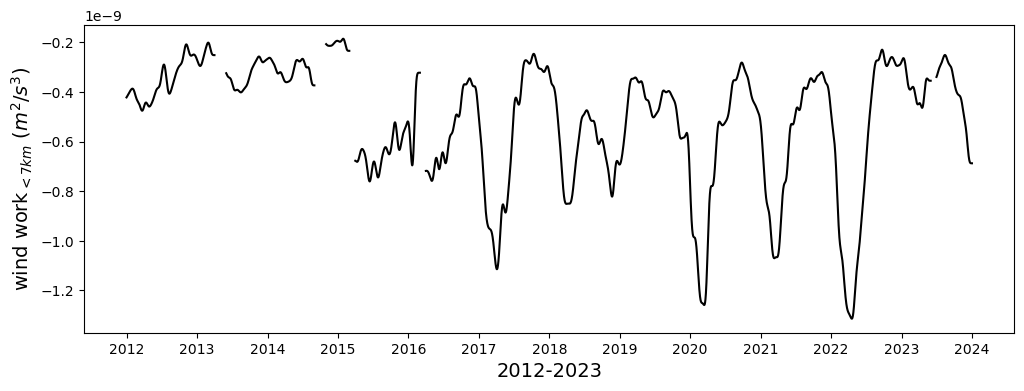

In [21]:
plt.figure(figsize=(12,4))
plt.plot(windwork, c = 'k')
tickpositions = [0, 8784,17544, 26304, 35064, 43848, 52608, 61368, 70128, 78912, 87672, 96432, 105191]
ticklabels = ['2012', '2013', '2014', '2015', '2016', '2017', '2018', '2019', '2020', '2021', '2022', '2023', '2024'] 
plt.xticks(tickpositions, ticklabels)
# plt.title('wind work 2012-2023 (scales < 7 km)')
plt.xlabel('2012-2023', fontsize=14)
# plt.ylim (-1.5e-9,0)
plt.ylabel('wind work$_{<7 km}$ ($m^2/s^3$)', fontsize=14)
plt.savefig("WWtimeseries.jpg", dpi=300)
plt.show()

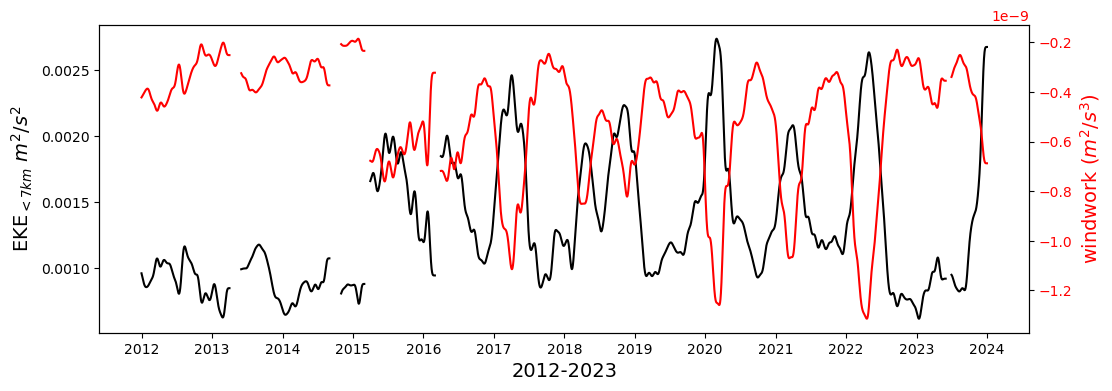

In [22]:
# two axis deal to compare magnitudes of the windwork and the kinetic energy at scales smaller than 7 km.
fig, ax1 = plt.subplots(figsize=(12,4))
ax1.plot(filteredseasonaleke7, 'k-')

# ax1.set_ylabel(r'$\P', color='k')
ax2 = ax1.twinx()
ax2.plot((windwork), 'r-')
ax2.set_ylabel(r'windwork ($m^2/s^3$)', color='r', fontsize=14)
ax2.tick_params(axis='y', labelcolor='red')
ax1.tick_params(axis='y', labelcolor='black')
tickpositions = [0, 8784,17544, 26304, 35064, 43848, 52608, 61368, 70128, 78912, 87672, 96432, 105191]
ticklabels = ['2012', '2013', '2014', '2015', '2016', '2017', '2018', '2019', '2020', '2021', '2022', '2023', '2024'] 
plt.xticks(tickpositions, ticklabels)
ax1.set_xlabel('2012-2023', fontsize=14)
ax1.set_ylabel('EKE$_{< 7 km}$ $m^2/s^2$', fontsize=14)

# plt.title('comparing seasonally averaged $\Pi$ and $\delta$ flux term over the region')
plt.savefig("WWEKE7timeseries.jpg", dpi=300)
plt.show()

Now need to reload in the vorticity calculated earlier to compare the wind work with the vorticity (as detailed in the manuscript)

Will load it in the same way as Figure 1 but will not average over time for the spatial plot, instead, will average over space for a time series.
Again, the vorticity is left for you to load in since everyone saves their data differently.

In [26]:
vorticity = 

In [27]:
# averaging the vorticity over the Santa Barbara Channel region for a 12-year timeseries.
vort = np.nanmean(vorticity[:,61:78,28:62], axis=(1,2))

In [28]:
# creating the time series with the same gapping and the butterworth filter
vort1 = vort[0:10944]
vort2 = vort[11357:22325]
vort3 = vort[23736:26616]
vort4 = vort[27356:35396]
vort5 = vort[36138:98946]
vort6 = vort[99658:104074]


In [29]:
# completing the same averaging and splitting as did with the wind work to account for the gaps in the HF radar data; this time with the vorticity to create the time series plot
seasonalvort1 = []
seasonalvort2 = []
seasonalvort3 = []
seasonalvort4 = []
seasonalvort5 = []
seasonalvort6 = []

for p in range(0, (len(vort1))):
    seasonalvort1.append(np.nanmean(vort1[p:p+2193]))
    
for p in range(0, (len(vort2))):
    seasonalvort2.append(np.nanmean(vort2[p:p+2193]))
    
for p in range(0, (len(vort3))):
    seasonalvort3.append(np.nanmean(vort3[p:p+2193]))
    
for p in range(0, (len(vort4))):
    seasonalvort4.append(np.nanmean(vort4[p:p+2193]))
    
for p in range(0, (len(vort5))):
    seasonalvort5.append(np.nanmean(vort5[p:p+2193]))
    
for p in range(0, (len(vort6))):
    seasonalvort6.append(np.nanmean(vort6[p:p+2193]))

In [30]:
hours = len(seasonalvort1)
t = np.arange(hours)  # Time vector in hours to pass through the butterworth filter function
data = seasonalvort1
T = 1  # Sampling interval in hours
fs = 1 / T  # Sampling frequency in cycles per hour
nyquist = 0.5 * fs  # Nyquist frequency in cycles per hour

cutoff = 1 / 732  # Desired cutoff frequency in cycles per hour (1 cycle per x months)
normal_cutoff = cutoff / nyquist  # Normalise by Nyquist frequency

# same butterworth_filter function used above
def butterworth_filter(data, normal_cutoff, order=5, filter_type='low'):
    b, a = butter(order, normal_cutoff, btype=filter_type, analog=False)
    y = filtfilt(b, a, data)
    return y

filteredseasonalvort1 = butterworth_filter(data, normal_cutoff, order=5, filter_type='low')

In [31]:
hours = len(seasonalvort2)
t = np.arange(hours)  # Time vector in hours to pass through the butterworth filter function
data = seasonalvort2
T = 1  # Sampling interval in hours
fs = 1 / T  # Sampling frequency in cycles per hour
nyquist = 0.5 * fs  # Nyquist frequency in cycles per hour

cutoff = 1 / 732  # Desired cutoff frequency in cycles per hour (1 cycle per x months)
normal_cutoff = cutoff / nyquist  # Normalise by Nyquist frequency

# same butterworth_filter function used above
def butterworth_filter(data, normal_cutoff, order=5, filter_type='low'):
    b, a = butter(order, normal_cutoff, btype=filter_type, analog=False)
    y = filtfilt(b, a, data)
    return y

filteredseasonalvort2 = butterworth_filter(data, normal_cutoff, order=5, filter_type='low')

In [32]:
hours = len(seasonalvort3)
t = np.arange(hours)  # Time vector in hours to pass through the butterworth filter function
data = seasonalvort3
T = 1  # Sampling interval in hours
fs = 1 / T  # Sampling frequency in cycles per hour
nyquist = 0.5 * fs  # Nyquist frequency in cycles per hour

cutoff = 1 / 732  # Desired cutoff frequency in cycles per hour (1 cycle per x months)
normal_cutoff = cutoff / nyquist  # Normalise by Nyquist frequency

# same butterworth_filter function used above
def butterworth_filter(data, normal_cutoff, order=5, filter_type='low'):
    b, a = butter(order, normal_cutoff, btype=filter_type, analog=False)
    y = filtfilt(b, a, data)
    return y

filteredseasonalvort3 = butterworth_filter(data, normal_cutoff, order=5, filter_type='low')

In [33]:
hours = len(seasonalvort4)
t = np.arange(hours)  # Time vector in hours to pass through the butterworth filter function
data = seasonalvort4
T = 1  # Sampling interval in hours
fs = 1 / T  # Sampling frequency in cycles per hour
nyquist = 0.5 * fs  # Nyquist frequency in cycles per hour

cutoff = 1 / 732  # Desired cutoff frequency in cycles per hour (1 cycle per x months)
normal_cutoff = cutoff / nyquist  # Normalise by Nyquist frequency

# same butterworth_filter function used above
def butterworth_filter(data, normal_cutoff, order=5, filter_type='low'):
    b, a = butter(order, normal_cutoff, btype=filter_type, analog=False)
    y = filtfilt(b, a, data)
    return y

filteredseasonalvort4 = butterworth_filter(data, normal_cutoff, order=5, filter_type='low')

In [34]:
hours = len(seasonalvort5)
t = np.arange(hours)  # Time vector in hours to pass through the butterworth filter function
data = seasonalvort5
T = 1  # Sampling interval in hours
fs = 1 / T  # Sampling frequency in cycles per hour
nyquist = 0.5 * fs  # Nyquist frequency in cycles per hour

cutoff = 1 / 732  # Desired cutoff frequency in cycles per hour (1 cycle per x months)
normal_cutoff = cutoff / nyquist  # Normalise by Nyquist frequency

# same butterworth_filter function used above
def butterworth_filter(data, normal_cutoff, order=5, filter_type='low'):
    b, a = butter(order, normal_cutoff, btype=filter_type, analog=False)
    y = filtfilt(b, a, data)
    return y

filteredseasonalvort5 = butterworth_filter(data, normal_cutoff, order=5, filter_type='low')

In [ ]:
hours = len(seasonalvort6)
t = np.arange(hours)  # Time vector in hours to pass through the butterworth filter function
data = seasonalvort6
T = 1  # Sampling interval in hours
fs = 1 / T  # Sampling frequency in cycles per hour
nyquist = 0.5 * fs  # Nyquist frequency in cycles per hour

cutoff = 1 / 732  # Desired cutoff frequency in cycles per hour (1 cycle per x months)
normal_cutoff = cutoff / nyquist  # Normalise by Nyquist frequency

# same butterworth_filter function used above
def butterworth_filter(data, normal_cutoff, order=5, filter_type='low'):
    b, a = butter(order, normal_cutoff, btype=filter_type, analog=False)
    y = filtfilt(b, a, data)
    return y

filteredseasonalvort6 = butterworth_filter(data, normal_cutoff, order=5, filter_type='low')

In [36]:
"""
concatenate each section but fill in gaps with NaN values
since seasonally averaged then concatenated, need to cut off some values which will affect the nan arrays too
"""
nan1 = np.full(1464, np.nan)
nan2 = np.full(744, np.nan)
nan3 = np.full(720, np.nan)
filteredvort = np.concatenate((filteredseasonalvort1, nan1, filteredseasonalvort2, nan1, filteredseasonalvort3, nan2, filteredseasonalvort4, nan2, filteredseasonalvort5, nan3, filteredseasonalvort6), axis=0)


In [24]:
# this is just he wind speed - full time series over the 12 years.
hours = len(seasonalwind)
t = np.arange(hours)  # Time vector in hours to pass through the butterworth filter function
data = seasonalwind
T = 1  # Sampling interval in hours
fs = 1 / T  # Sampling frequency in cycles per hour
nyquist = 0.5 * fs  # Nyquist frequency in cycles per hour

cutoff = 1 / 732  # Desired cutoff frequency in cycles per hour (1 cycle per x months)
normal_cutoff = cutoff / nyquist  # Normalise by Nyquist frequency

# same butterworth_filter function used above
def butterworth_filter(data, normal_cutoff, order=5, filter_type='low'):
    b, a = butter(order, normal_cutoff, btype=filter_type, analog=False)
    y = filtfilt(b, a, data)
    return y

filteredseasonalwind = butterworth_filter(data, normal_cutoff, order=5, filter_type='low')

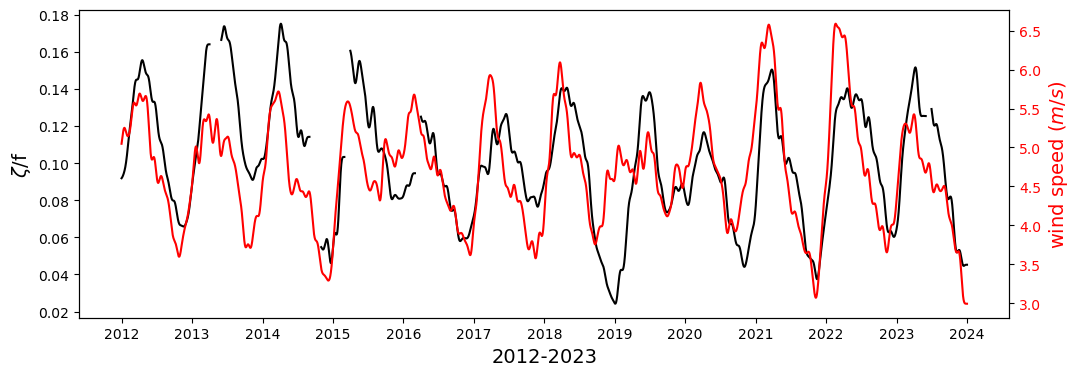

In [39]:
# two axis deal to compare magnitudes and graphing vorticity and wind speed
fig, ax1 = plt.subplots(figsize=(12,4))
ax1.plot(filteredvort, 'k-')
ax1.set_ylabel(r'$\zeta$/f', color='k', fontsize=14)
ax2 = ax1.twinx()
ax2.plot(filteredseasonalwind, 'r-')
ax2.set_ylabel(r'wind speed ($m/s$)', color='r', fontsize=14)
ax2.tick_params(axis='y', labelcolor='red')
ax1.tick_params(axis='y', labelcolor='black')
tickpositions = [0, 8784,17544, 26304, 35064, 43848, 52608, 61368, 70128, 78912, 87672, 96432, 105191]
ticklabels = ['2012', '2013', '2014', '2015', '2016', '2017', '2018', '2019', '2020', '2021', '2022', '2023', '2024'] 
plt.xticks(tickpositions, ticklabels)
ax1.set_xlabel('2012-2023', fontsize=14)
plt.savefig("VortWindspeedtimeseries.jpg", dpi=300)
plt.show()

### Phase space plots - Figure 2 (d), (e), and (f)

Creating phase space plots to show the seasonality of the different features.

You can do this just by creating a scatter plot of the parameters and applying a colorbar scheme that chances with the season so you can see the changes over time.

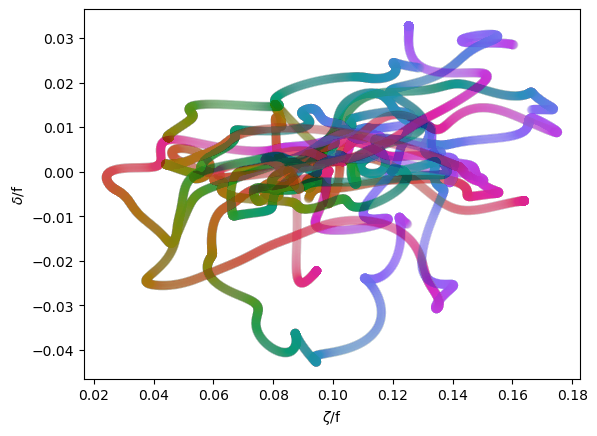

In [122]:
"""
hard coded phase space plots of wind work and EKE, wind work and the time derivative of the KE and wind speed against vorticity.
wind speed and vorticity shown below as example.
"""

time = np.linspace(0, 105192, 105192)
time1 = np.linspace(0, 8784, 8784)
scatter = plt.scatter(filteredvort[:8784], filteredseasonalwind[:8784], c=time[:8784], cmap=cmocean.cm.phase, alpha = 0.01)
plt.scatter(filteredvort[8784:16493], filteredseasonalwind[8784:16493], c=time[8784:16493], cmap=cmocean.cm.phase, alpha = 0.01)
plt.scatter(filteredvort[16493:25200], filteredseasonalwind[16493:25200], c=time[16493:25200], cmap=cmocean.cm.phase, alpha = 0.01)
plt.scatter(filteredvort[25200:33956], filteredseasonalwind[25200:33956], c=time[25200:33956], cmap=cmocean.cm.phase, alpha = 0.01)
plt.scatter(filteredvort[33956:42738], filteredseasonalwind[33956:42738], c=time[33956:42738], cmap=cmocean.cm.phase, alpha = 0.01)
plt.scatter(filteredvort[42738:51498], filteredseasonalwind[42738:51498], c=time[42738:51498], cmap=cmocean.cm.phase, alpha = 0.01)
plt.scatter(filteredvort[51498:60258], filteredseasonalwind[51498:60258], c=time[51498:60258], cmap=cmocean.cm.phase, alpha = 0.01)
plt.scatter(filteredvort[60258:69018], filteredseasonalwind[60258:69018], c=time[60258:69018], cmap=cmocean.cm.phase, alpha = 0.01)
plt.scatter(filteredvort[69018:77802], filteredseasonalwind[69018:77802], c=time[69018:77802], cmap=cmocean.cm.phase, alpha = 0.01)
plt.scatter(filteredvort[77802:86562], filteredseasonalwind[77802:86562], c=time[77802:86562], cmap=cmocean.cm.phase, alpha = 0.01)
plt.scatter(filteredvort[86562:95322], filteredseasonalwind[86562:95322], c=time[86562:95322], cmap=cmocean.cm.phase, alpha = 0.01)
plt.scatter(filteredvort[95322:], filteredseasonalwind[95322:], c=time[95322:], cmap=cmocean.cm.phase, alpha=0.01)

# cbar=plt.colorbar(scatter)
# cbar.set_label('Month')
# cbar.set_ticks([0, 744, 1440, 2184, 2904, 3648, 4368, 5112, 5856, 6576, 7320, 8040])  # Set specific tick locations
# cbar.set_ticklabels(['Jan', 'Feb', 'March', 'April', 'May', 'June', 'July', 'August', 'Sept', 'Oct', 'Nov', 'Dec'])  # Set custom tick labels


plt.xlabel(r'$\zeta$/f')
plt.ylabel(r'Wind speed')
plt.show()